In [975]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

In [976]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv')

In [977]:
listings_df.head()

,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_date,year_of_construction,price
0,2 storey,1191,4076,3,1,2,Beauport,2020-12-01,2004,332500
1,Open area,1261,9500,2,1,1,Deschambault,2021-12-01,1957,265000
2,Unknown,1645,1360,3,1,3,Mercier,2021-11-01,2006,612000
3,Link,2024,17000,4,3,1,Stoneham,2021-12-01,2019,526500
4,2 storey,2400,4471,4,2,2,Gatineau,2021-12-01,1989,360000


## Adding columns

In [978]:
listings_df.insert(7, 'year', '')
listings_df['year'] = pd.DatetimeIndex(listings_df['listing_date']).year

## Correlation Heat Map

In [979]:
sns.set_theme(style="white")

def plot_corr_map(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

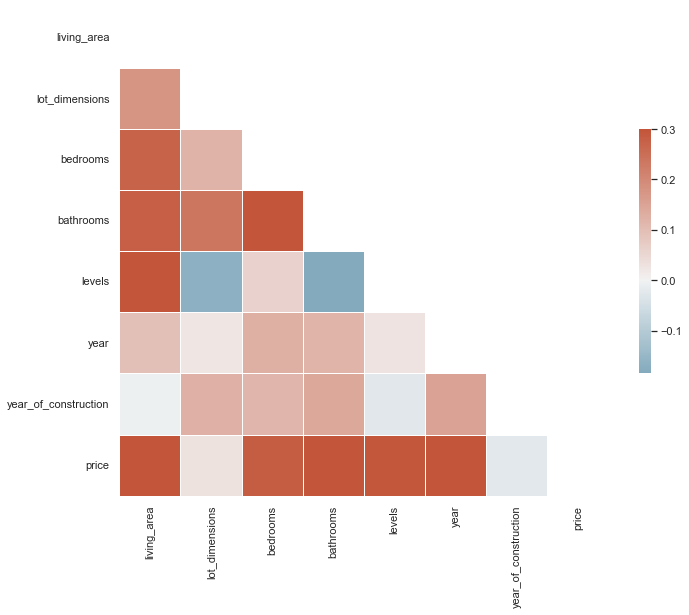

In [980]:
plot_corr_map(listings_df)

## Choosing columns

In [981]:
ordinal_cols = ['location', 'year']
one_hot_cols = ['bedrooms', 'bathrooms']
numerical_cols = ['living_area']
target_col = ['price']

In [982]:
listings_df = listings_df[ordinal_cols + one_hot_cols + numerical_cols + target_col]

## One Hot Encoding

In [983]:
def oh_encode(df_line, col, new_col, val):
    if df_line[col] == val:
        return df_line[new_col] + 1
    else:
        return df_line[new_col]

for col in one_hot_cols:
    for val in listings_df[col].unique():   
        new_col = str(val) + '_' + col
        listings_df[new_col] = 0
        listings_df[new_col] = listings_df.apply(oh_encode, args=(col, new_col, val), axis=1)

    listings_df = listings_df.drop(columns=[col])

In [984]:
listings_df.head()

,location,year,living_area,price,3_bedrooms,2_bedrooms,4_bedrooms,5_bedrooms,6_bedrooms,1_bedrooms,1_bathrooms,3_bathrooms,2_bathrooms,4_bathrooms
0,Beauport,2020,1191,332500,1,0,0,0,0,0,1,0,0,0
1,Deschambault,2021,1261,265000,0,1,0,0,0,0,1,0,0,0
2,Mercier,2021,1645,612000,1,0,0,0,0,0,1,0,0,0
3,Stoneham,2021,2024,526500,0,0,1,0,0,0,0,1,0,0
4,Gatineau,2021,2400,360000,0,0,1,0,0,0,0,0,1,0


## Spliting Data

In [985]:
y = listings_df[target_col]
X = listings_df.drop(columns=target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Ordinal Encoding

In [986]:
ordinal_encoders = {}

for col in ordinal_cols:
    ordinal_encoders[col] = OrdinalEncoder()
    X_train[col] = ordinal_encoders[col].fit_transform(X_train[[col]])
    X_test[col] = ordinal_encoders[col].transform(X_test[[col]])

## Scaling

In [987]:
scalers = {}

for col in numerical_cols:
    scalers[col] = MinMaxScaler(feature_range=(-1, 1))
    X_train[col] = scalers[col].fit_transform(X_train[[col]])
    X_test[col] = scalers[col].transform(X_test[[col]])

In [988]:
scale_target = True

if scale_target:
    target_scaler = MinMaxScaler((-1, 1))

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.fit_transform(y_test)

In [989]:
X_train.head()

,location,year,living_area,3_bedrooms,2_bedrooms,4_bedrooms,5_bedrooms,6_bedrooms,1_bedrooms,1_bathrooms,3_bathrooms,2_bathrooms,4_bathrooms
17498,3.0,14.0,-0.718497,0,0,1,0,0,0,0,0,1,0
58829,11.0,18.0,-0.734682,1,0,0,0,0,0,0,0,1,0
29760,4.0,9.0,-0.475723,1,0,0,0,0,0,0,0,1,0
41040,31.0,18.0,-0.387861,0,0,0,1,0,0,0,0,1,0
27406,27.0,11.0,-0.778613,0,0,1,0,0,0,1,0,0,0


In [990]:
y_train

array([[-0.53674607],
       [-0.21236695],
       [-0.38063862],
       ...,
       [-0.49619868],
       [-0.57729346],
       [-0.34921439]])

In [991]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.36109485683429143

# Neural Net

In [992]:
model = Sequential()
model.add(Dense(units=13, activation='tanh', input_shape=(X_train.shape[-1],)))
model.add(Dense(units=10, activation='tanh'))
model.add(Dense(units=4, activation='tanh'))
model.add(Dense(units=1, activation='tanh'))

print(model.summary())

model.compile(optimizer=Adam(lr=0.001), loss='mse')

history = model.fit(X_train, y_train, batch_size=1000, epochs=700, shuffle=True, verbose=1, validation_data=(X_test, y_test))

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           (None, 13)                182       
                                                                 
 dense_128 (Dense)           (None, 10)                140       
                                                                 
 dense_129 (Dense)           (None, 4)                 44        
                                                                 
 dense_130 (Dense)           (None, 1)                 5         
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/700


c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


48/48 [==============================] - 0s 3ms/step - loss: 0.4402 - val_loss: 0.1089
Epoch 2/700
48/48 [==============================] - 0s 1ms/step - loss: 0.0780 - val_loss: 0.0733
Epoch 3/700
48/48 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0632
Epoch 4/700
48/48 [==============================] - 0s 1ms/step - loss: 0.0515 - val_loss: 0.0543
Epoch 5/700
48/48 [==============================] - 0s 1ms/step - loss: 0.0441 - val_loss: 0.0480
Epoch 6/700
48/48 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0424
Epoch 7/700
48/48 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0391
Epoch 8/700
48/48 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0372
Epoch 9/700
48/48 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0361
Epoch 10/700
48/48 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0346
Epoch 11/700
48/48 [=

In [993]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

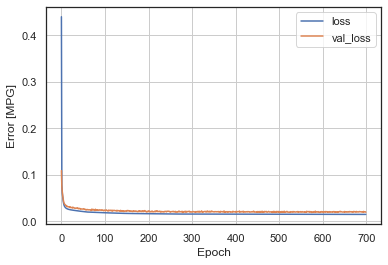

In [994]:
plot_loss(history)

In [995]:
sk_predicted_prices = target_scaler.inverse_transform(reg.predict(X_test))
tf_predicted_prices = target_scaler.inverse_transform(model.predict(X_test))
real_prices = target_scaler.inverse_transform(y_test)

In [996]:
test_df = X_test.copy()

In [997]:
for col in ordinal_cols:
    test_df[col] = ordinal_encoders[col].inverse_transform(test_df[[col]])

for col in numerical_cols:
    test_df[col] = scalers[col].inverse_transform(test_df[[col]])

In [998]:
d = {}
d['real price'] = list(real_prices)
d['sk predicted price'] = list(sk_predicted_prices)
d['tf predicted price'] = list(tf_predicted_prices)

test_df['real price'] = d['real price']
test_df['sk predicted price'] = d['sk predicted price']
test_df['tf predicted price'] = d['tf predicted price']

test_df['real price'] = test_df['real price'].astype(int)
test_df['sk predicted price'] = test_df['sk predicted price'].astype(int)
test_df['tf predicted price'] = test_df['tf predicted price'].astype(int)

In [999]:
test_df.head(30)

,location,year,living_area,3_bedrooms,2_bedrooms,4_bedrooms,5_bedrooms,6_bedrooms,1_bedrooms,1_bathrooms,3_bathrooms,2_bathrooms,4_bathrooms,real price,sk predicted price,tf predicted price
47648,Alma,2021,1800.0,0,0,0,1,0,0,0,0,1,0,284000,437759,306945
28551,Boucherville,2013,1183.0,0,0,0,1,0,0,0,0,1,0,295000,301592,331303
39252,Lévis,2005,1352.0,1,0,0,0,0,0,1,0,0,0,155000,189011,190407
34697,Gatineau,2010,1300.0,0,0,0,1,0,0,0,0,1,0,266000,280009,276676
32964,Neufchatel,2011,952.0,1,0,0,0,0,0,1,0,0,0,265000,242681,235525
23878,Boucherville,2013,2900.0,1,0,0,0,0,0,0,1,0,0,695000,475647,621489
37645,St-Augustin-De-Desmaures,2008,1568.0,0,0,1,0,0,0,1,0,0,0,265000,231030,274712
34727,La Prairie,2010,1674.0,0,0,0,1,0,0,0,0,1,0,330500,308621,371913
46894,Deschambault,2021,1261.0,0,1,0,0,0,0,1,0,0,0,265000,309425,290848
36602,Chambly,2009,1584.0,0,0,1,0,0,0,1,0,0,0,312000,222140,297002
